In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
import shap
shap.initjs()

In [70]:
def read_data(fname):
    """
    Reads a CSV file into a pandas DataFrame, identifies and removes duplicate rows,
    and prints information about the shape of the data before and after duplicate removal.

    Parameters:
    -----------
    fname : str
        The filename or path to the CSV file to be read.

    Returns:
    --------
    pd.DataFrame
        The DataFrame containing the data from the CSV file after removing duplicates.

    """
    df = pd.read_csv(fname)
    print("Data shape raw               : ", df.shape)
    num_duplicated = df.duplicated().sum()
    print("Number of duplicate order id : ",num_duplicated)
    df = df.drop_duplicates(keep='last')
    print("Data shape after dropping    : ", df.shape)
    print("Data shape final             : ", df.shape)
    return df

In [71]:
data = read_data(fname='player_mvp_stats.csv')

Data shape raw               :  (14018, 41)
Number of duplicate order id :  0
Data shape after dropping    :  (14018, 41)
Data shape final             :  (14018, 41)


In [72]:
data.head()

,Unnamed: 0,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
0,0,Doc Rivers,29.0,Atlanta Hawks,PG,79.0,79.0,32.7,5.6,12.9,...,0.0,0.0,0.00,43.0,39.0,0.524,18.0,109.8,109.0,0.72
1,1,Dominique Wilkins,31.0,Atlanta Hawks,SF,81.0,81.0,38.0,9.5,20.2,...,29.0,960.0,0.03,43.0,39.0,0.524,18.0,109.8,109.0,0.72
2,2,Duane Ferrell,25.0,Atlanta Hawks,SF,78.0,2.0,14.9,2.2,4.6,...,0.0,0.0,0.00,43.0,39.0,0.524,18.0,109.8,109.0,0.72
3,3,Gary Leonard,23.0,Atlanta Hawks,C,4.0,0.0,2.3,0.0,0.0,...,0.0,0.0,0.00,43.0,39.0,0.524,18.0,109.8,109.0,0.72
4,4,John Battle,28.0,Atlanta Hawks,SG,79.0,2.0,23.6,5.0,10.9,...,0.0,0.0,0.00,43.0,39.0,0.524,18.0,109.8,109.0,0.72


In [73]:
del data['Unnamed: 0']

In [74]:
data.columns

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Pts Won', 'Pts Max', 'Share', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G',
       'SRS'],
      dtype='object')

In [75]:
for col in data.columns:
    print(f"{col}: {data[col].dtype}")

Player: object
Age: float64
Team: object
Pos: object
G: float64
GS: float64
MP: float64
FG: float64
FGA: float64
FG%: float64
3P: float64
3PA: float64
3P%: float64
2P: float64
2PA: float64
2P%: float64
eFG%: float64
FT: float64
FTA: float64
FT%: float64
ORB: float64
DRB: float64
TRB: float64
AST: float64
STL: float64
BLK: float64
TOV: float64
PF: float64
PTS: float64
Year: int64
Pts Won: float64
Pts Max: float64
Share: float64
W: float64
L: float64
W/L%: float64
GB: float64
PS/G: float64
PA/G: float64
SRS: float64


In [76]:
data['Pos'].unique()

array(['PG', 'SF', 'C', 'SG', 'PF', '0'], dtype=object)

In [77]:
data['Pos'] = data['Pos'].apply(lambda x: x.split('-')[0])

In [78]:
def split_train_valid_test(data,year_train,year_test):
    train = data[data['Year'] <= year_train]
    test = data[data['Year'] == year_test]

    return train,test 

In [79]:
train,test = split_train_valid_test(data,2023,2024)

In [80]:
print(data.columns)

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Pts Won', 'Pts Max', 'Share', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G',
       'SRS'],
      dtype='object')


In [81]:
def split_input_output(data_train,data_test,target_col,unused_col):
   
    y_train = data_train[target_col]
    X_train = data_train.drop(columns=[target_col] + unused_col)
    y_test = data_test[target_col]
    X_test = data_test.drop(columns=[target_col] + unused_col)
    
    print(f'X shape: {X_train.shape}')
    print(f'y shape: {y_train.shape}')
    print(f'X shape: {X_test.shape}')
    print(f'y shape: {y_test.shape}')
    
    return X_train, y_train, X_test, y_test

In [82]:
X_train, y_train, X_test, y_test = split_input_output(data_train=train, data_test=test,
                                        target_col='Share', 
                                        unused_col=['Pts Won', 'Pts Max'])

X shape: (13523, 37)
y shape: (13523,)
X shape: (495, 37)
y shape: (495,)


In [83]:
X_train.head()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,PF,PTS,Year,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Doc Rivers,29.0,Atlanta Hawks,PG,79.0,79.0,32.7,5.6,12.9,0.435,...,2.7,15.2,1991,43.0,39.0,0.524,18.0,109.8,109.0,0.72
1,Dominique Wilkins,31.0,Atlanta Hawks,SF,81.0,81.0,38.0,9.5,20.2,0.470,...,1.9,25.9,1991,43.0,39.0,0.524,18.0,109.8,109.0,0.72
2,Duane Ferrell,25.0,Atlanta Hawks,SF,78.0,2.0,14.9,2.2,4.6,0.489,...,1.9,6.1,1991,43.0,39.0,0.524,18.0,109.8,109.0,0.72
3,Gary Leonard,23.0,Atlanta Hawks,C,4.0,0.0,2.3,0.0,0.0,0.000,...,0.5,0.5,1991,43.0,39.0,0.524,18.0,109.8,109.0,0.72
4,John Battle,28.0,Atlanta Hawks,SG,79.0,2.0,23.6,5.0,10.9,0.461,...,1.8,13.6,1991,43.0,39.0,0.524,18.0,109.8,109.0,0.72


In [84]:
y_train.head()

0    0.00
1    0.03
2    0.00
3    0.00
4    0.00
Name: Share, dtype: float64

In [85]:
def split_numerical_categorical(data, num_cols, cat_cols):
    num_cols = [col for col in num_cols if col in data.columns]
    cat_cols = [col for col in cat_cols if col in data.columns]

    if not num_cols:
        print("Warning: No numerical columns found.")
    if not cat_cols:
        print("Warning: No categorical columns found.")

    numerical_data = data[num_cols]
    categorical_data = data[cat_cols]
    
    print(f'Data num shape: {numerical_data.shape}')
    print(f'Data cat shape: {categorical_data.shape}')

    return numerical_data, categorical_data

In [86]:
num_column = ['Age','G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS','PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP','W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS']

In [87]:
cat_column = ['Pos']

In [88]:
X_train_num, X_train_cat = split_numerical_categorical(data=X_train,num_cols=num_column,cat_cols=cat_column)

Data num shape: (13523, 33)
Data cat shape: (13523, 1)


In [89]:
print(X_train.columns)

Index(['Player', 'Age', 'Team', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS'],
      dtype='object')


In [90]:
print(cat_column)

['Pos']


In [91]:
numerical_df = data[[col for col in data.columns if data[col].dtype in ['int64', 'float64']]]

In [92]:
corr_num = numerical_df.corr()['Share']
plt.figure(figsize=(32,24))
corr_num.plot.bar()
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel('X Axis Title', fontsize=28)
plt.ylabel('Y Axis Title', fontsize=28)
plt.title('Correlation to Share', fontsize=32)

Text(0.5, 1.0, 'Correlation to Share')

In [93]:
numerical_df.corr()['Share'].sort_values(ascending=False)

Share      1.000000
Pts Won    0.994681
Pts Max    0.523153
FTA        0.331375
FT         0.326244
PTS        0.292647
2P         0.284447
FG         0.281014
2PA        0.258838
FGA        0.252252
TOV        0.239876
DRB        0.225540
AST        0.208227
TRB        0.197092
STL        0.176660
GS         0.169732
MP         0.163270
BLK        0.155929
W/L%       0.127499
W          0.123888
SRS        0.122806
ORB        0.105028
3PA        0.092556
3P         0.091678
G          0.090945
PF         0.076331
FG%        0.065205
2P%        0.058378
eFG%       0.056476
FT%        0.041863
PS/G       0.033843
3P%        0.031345
Age        0.021753
Year      -0.008337
PA/G      -0.027906
GB        -0.102262
L         -0.121684
Name: Share, dtype: float64

In [94]:
year_share_mvp = data.groupby('Year')['Share'].max().reset_index()

In [95]:
data_mvp_by_year = pd.merge(data, year_share_mvp, on=['Year', 'Share'])

In [96]:
data_mvp_by_year.sort_values('Year', ascending=True)

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Michael Jordan,27.0,Chicago Bulls,SG,82.0,82.0,37.0,12.1,22.4,0.539,...,891.0,960.0,0.928,61.0,21.0,0.744,0.0,110.0,101.0,8.57
1,Michael Jordan,28.0,Chicago Bulls,SG,80.0,80.0,38.8,11.8,22.7,0.519,...,900.0,960.0,0.938,67.0,15.0,0.817,0.0,109.9,99.5,10.07
26,Charles Barkley,29.0,Phoenix Suns,PF,76.0,76.0,37.6,9.4,18.1,0.520,...,835.0,980.0,0.852,62.0,20.0,0.756,0.0,113.4,106.7,6.27
13,Hakeem Olajuwon,31.0,Houston Rockets,C,80.0,80.0,41.0,11.2,21.2,0.528,...,889.0,1010.0,0.880,58.0,24.0,0.707,0.0,101.1,96.8,4.19
29,David Robinson,29.0,San Antonio Spurs,C,81.0,81.0,38.0,9.7,18.4,0.530,...,901.0,1050.0,0.858,62.0,20.0,0.756,0.0,106.6,100.6,5.90
2,Michael Jordan,32.0,Chicago Bulls,SG,82.0,82.0,37.7,11.2,22.6,0.495,...,1114.0,1130.0,0.986,72.0,10.0,0.878,0.0,105.2,92.9,11.80
32,Karl Malone,33.0,Utah Jazz,PF,82.0,82.0,36.6,10.5,19.2,0.550,...,986.0,1150.0,0.857,64.0,18.0,0.780,0.0,103.1,94.3,7.97
3,Michael Jordan,34.0,Chicago Bulls,SG,82.0,82.0,38.8,10.7,23.1,0.465,...,1084.0,1160.0,0.934,62.0,20.0,0.756,0.0,96.7,89.6,7.24
33,Karl Malone,35.0,Utah Jazz,PF,49.0,49.0,37.4,8.0,16.3,0.493,...,827.0,1180.0,0.701,37.0,13.0,0.740,0.0,93.3,86.8,5.54
15,Shaquille O'Neal,27.0,Los Angeles Lakers,C,79.0,79.0,40.0,12.1,21.1,0.574,...,1207.0,1210.0,0.998,67.0,15.0,0.817,0.0,100.8,92.3,8.41


In [97]:
len(data.columns)

40

In [98]:
for_plot = data_mvp_by_year[['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 
      'Pts Won', 'Pts Max', 'Share','W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS']]

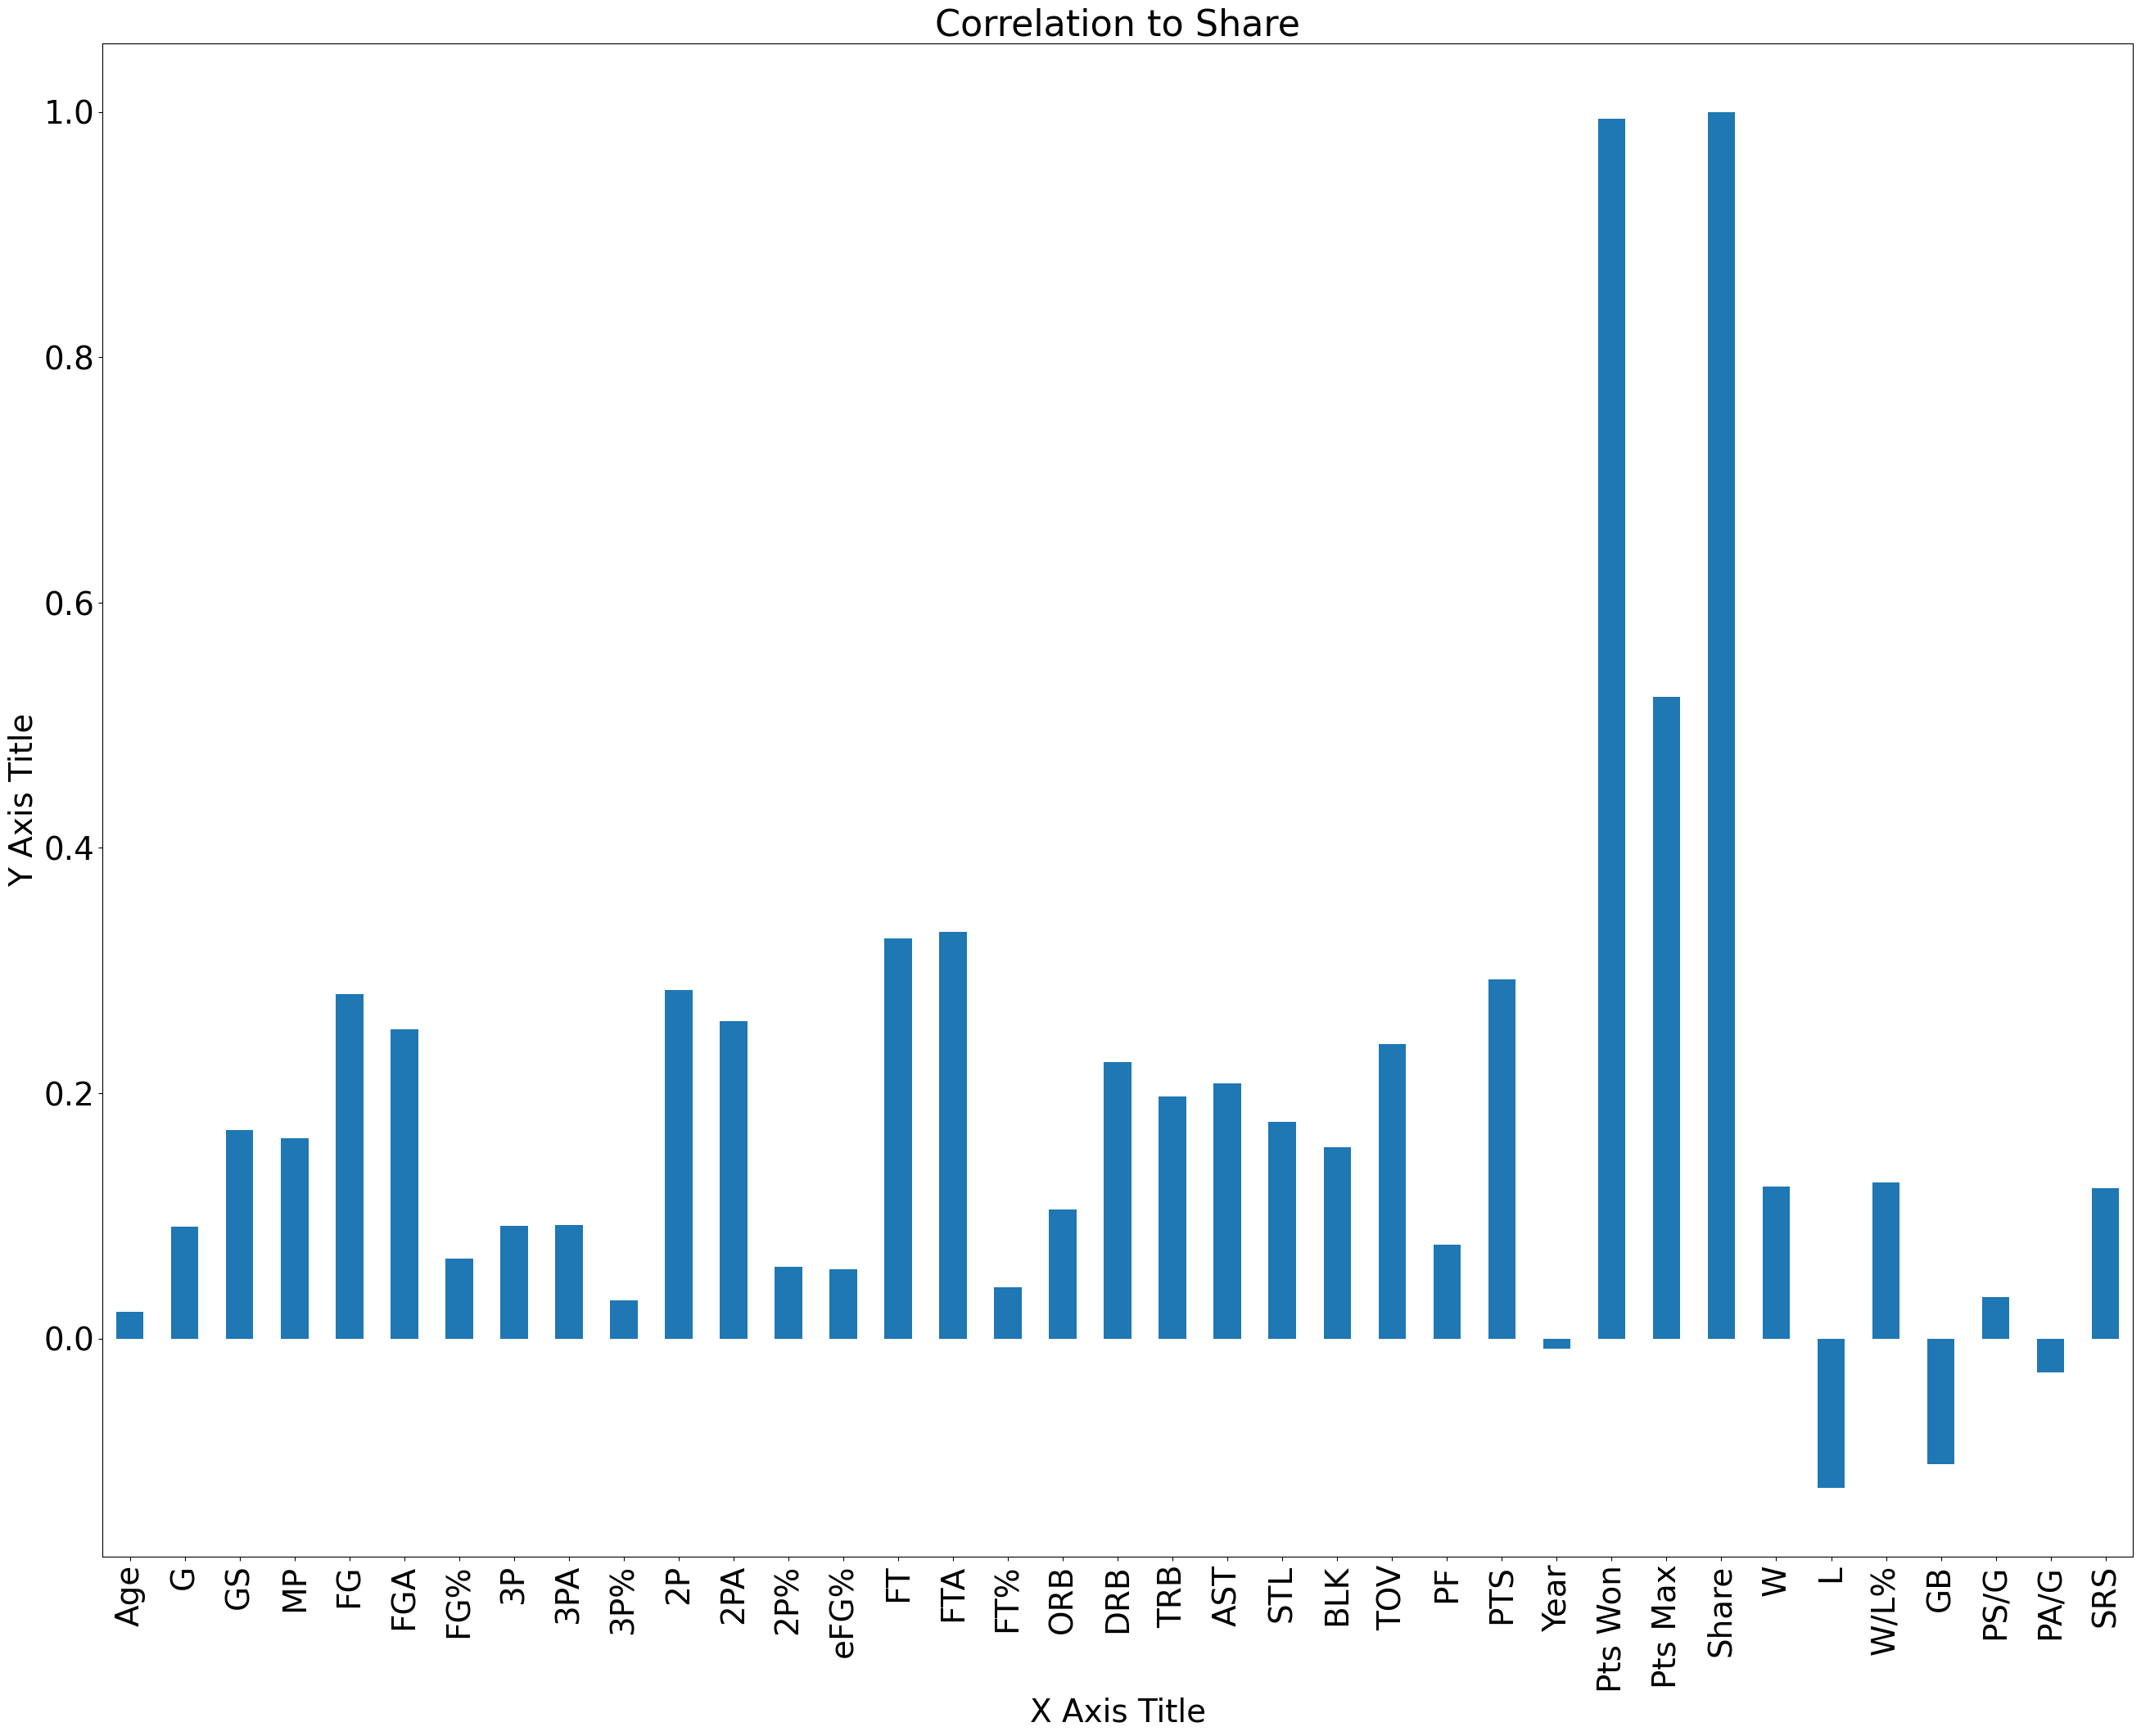

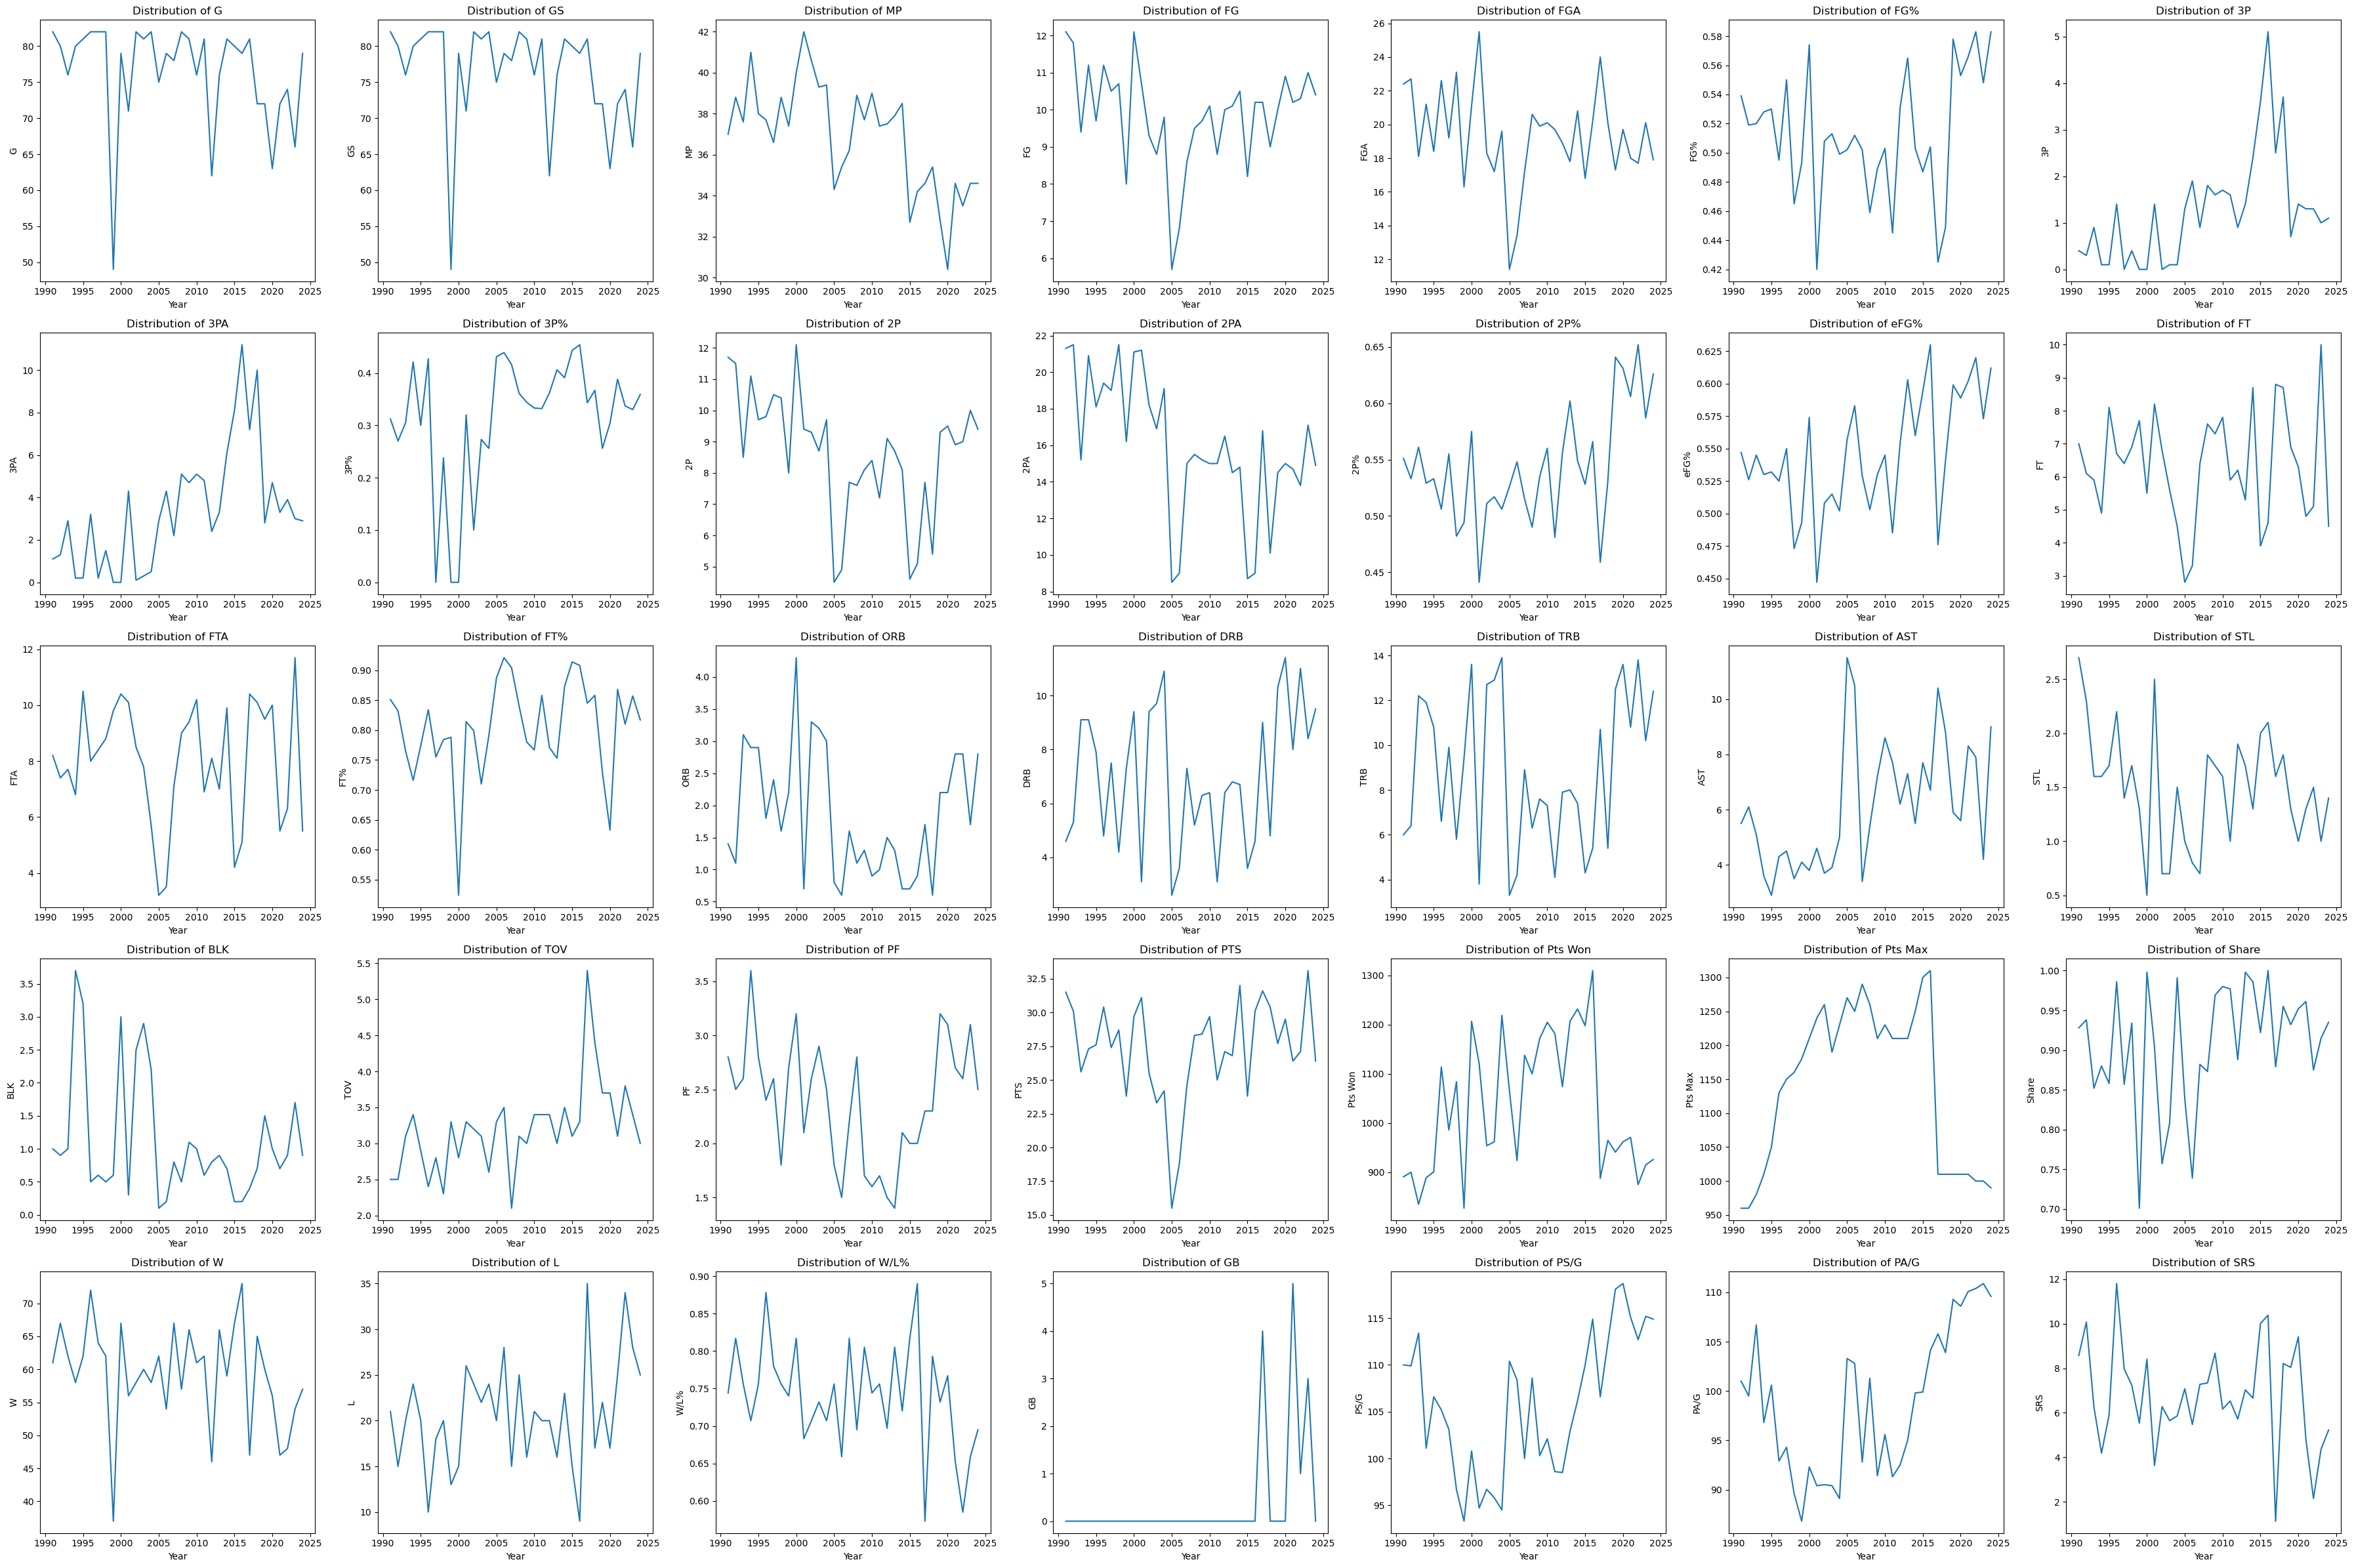

In [99]:
fig, ax = plt.subplots(nrows=5, ncols=7, figsize=(36, 24))
axes = ax.flatten()

for i, col in enumerate(for_plot.columns):
    sns.lineplot(x=data_mvp_by_year['Year'],y=for_plot[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [100]:
for_plot.min()

G           49.000
GS          49.000
MP          30.400
FG           5.700
FGA         11.400
FG%          0.420
3P           0.000
3PA          0.000
3P%          0.000
2P           4.500
2PA          8.500
2P%          0.441
eFG%         0.447
FT           2.800
FTA          3.200
FT%          0.524
ORB          0.600
DRB          2.600
TRB          3.300
AST          2.900
STL          0.500
BLK          0.100
TOV          2.100
PF           1.400
PTS         15.500
Pts Won    827.000
Pts Max    960.000
Share        0.701
W           37.000
L            9.000
W/L%         0.573
GB           0.000
PS/G        93.300
PA/G        86.800
SRS          1.140
dtype: float64

In [101]:
numerical_df.corr()['Share'].sort_values(ascending=False)

Share      1.000000
Pts Won    0.994681
Pts Max    0.523153
FTA        0.331375
FT         0.326244
PTS        0.292647
2P         0.284447
FG         0.281014
2PA        0.258838
FGA        0.252252
TOV        0.239876
DRB        0.225540
AST        0.208227
TRB        0.197092
STL        0.176660
GS         0.169732
MP         0.163270
BLK        0.155929
W/L%       0.127499
W          0.123888
SRS        0.122806
ORB        0.105028
3PA        0.092556
3P         0.091678
G          0.090945
PF         0.076331
FG%        0.065205
2P%        0.058378
eFG%       0.056476
FT%        0.041863
PS/G       0.033843
3P%        0.031345
Age        0.021753
Year      -0.008337
PA/G      -0.027906
GB        -0.102262
L         -0.121684
Name: Share, dtype: float64

In [102]:
data_mvp_by_year.min()

Player     Allen Iverson
Age                 22.0
Team       Chicago Bulls
Pos                    C
G                   49.0
GS                  49.0
MP                  30.4
FG                   5.7
FGA                 11.4
FG%                 0.42
3P                   0.0
3PA                  0.0
3P%                  0.0
2P                   4.5
2PA                  8.5
2P%                0.441
eFG%               0.447
FT                   2.8
FTA                  3.2
FT%                0.524
ORB                  0.6
DRB                  2.6
TRB                  3.3
AST                  2.9
STL                  0.5
BLK                  0.1
TOV                  2.1
PF                   1.4
PTS                 15.5
Year                1991
Pts Won            827.0
Pts Max            960.0
Share              0.701
W                   37.0
L                    9.0
W/L%               0.573
GB                   0.0
PS/G                93.3
PA/G                86.8
SRS                 1.14


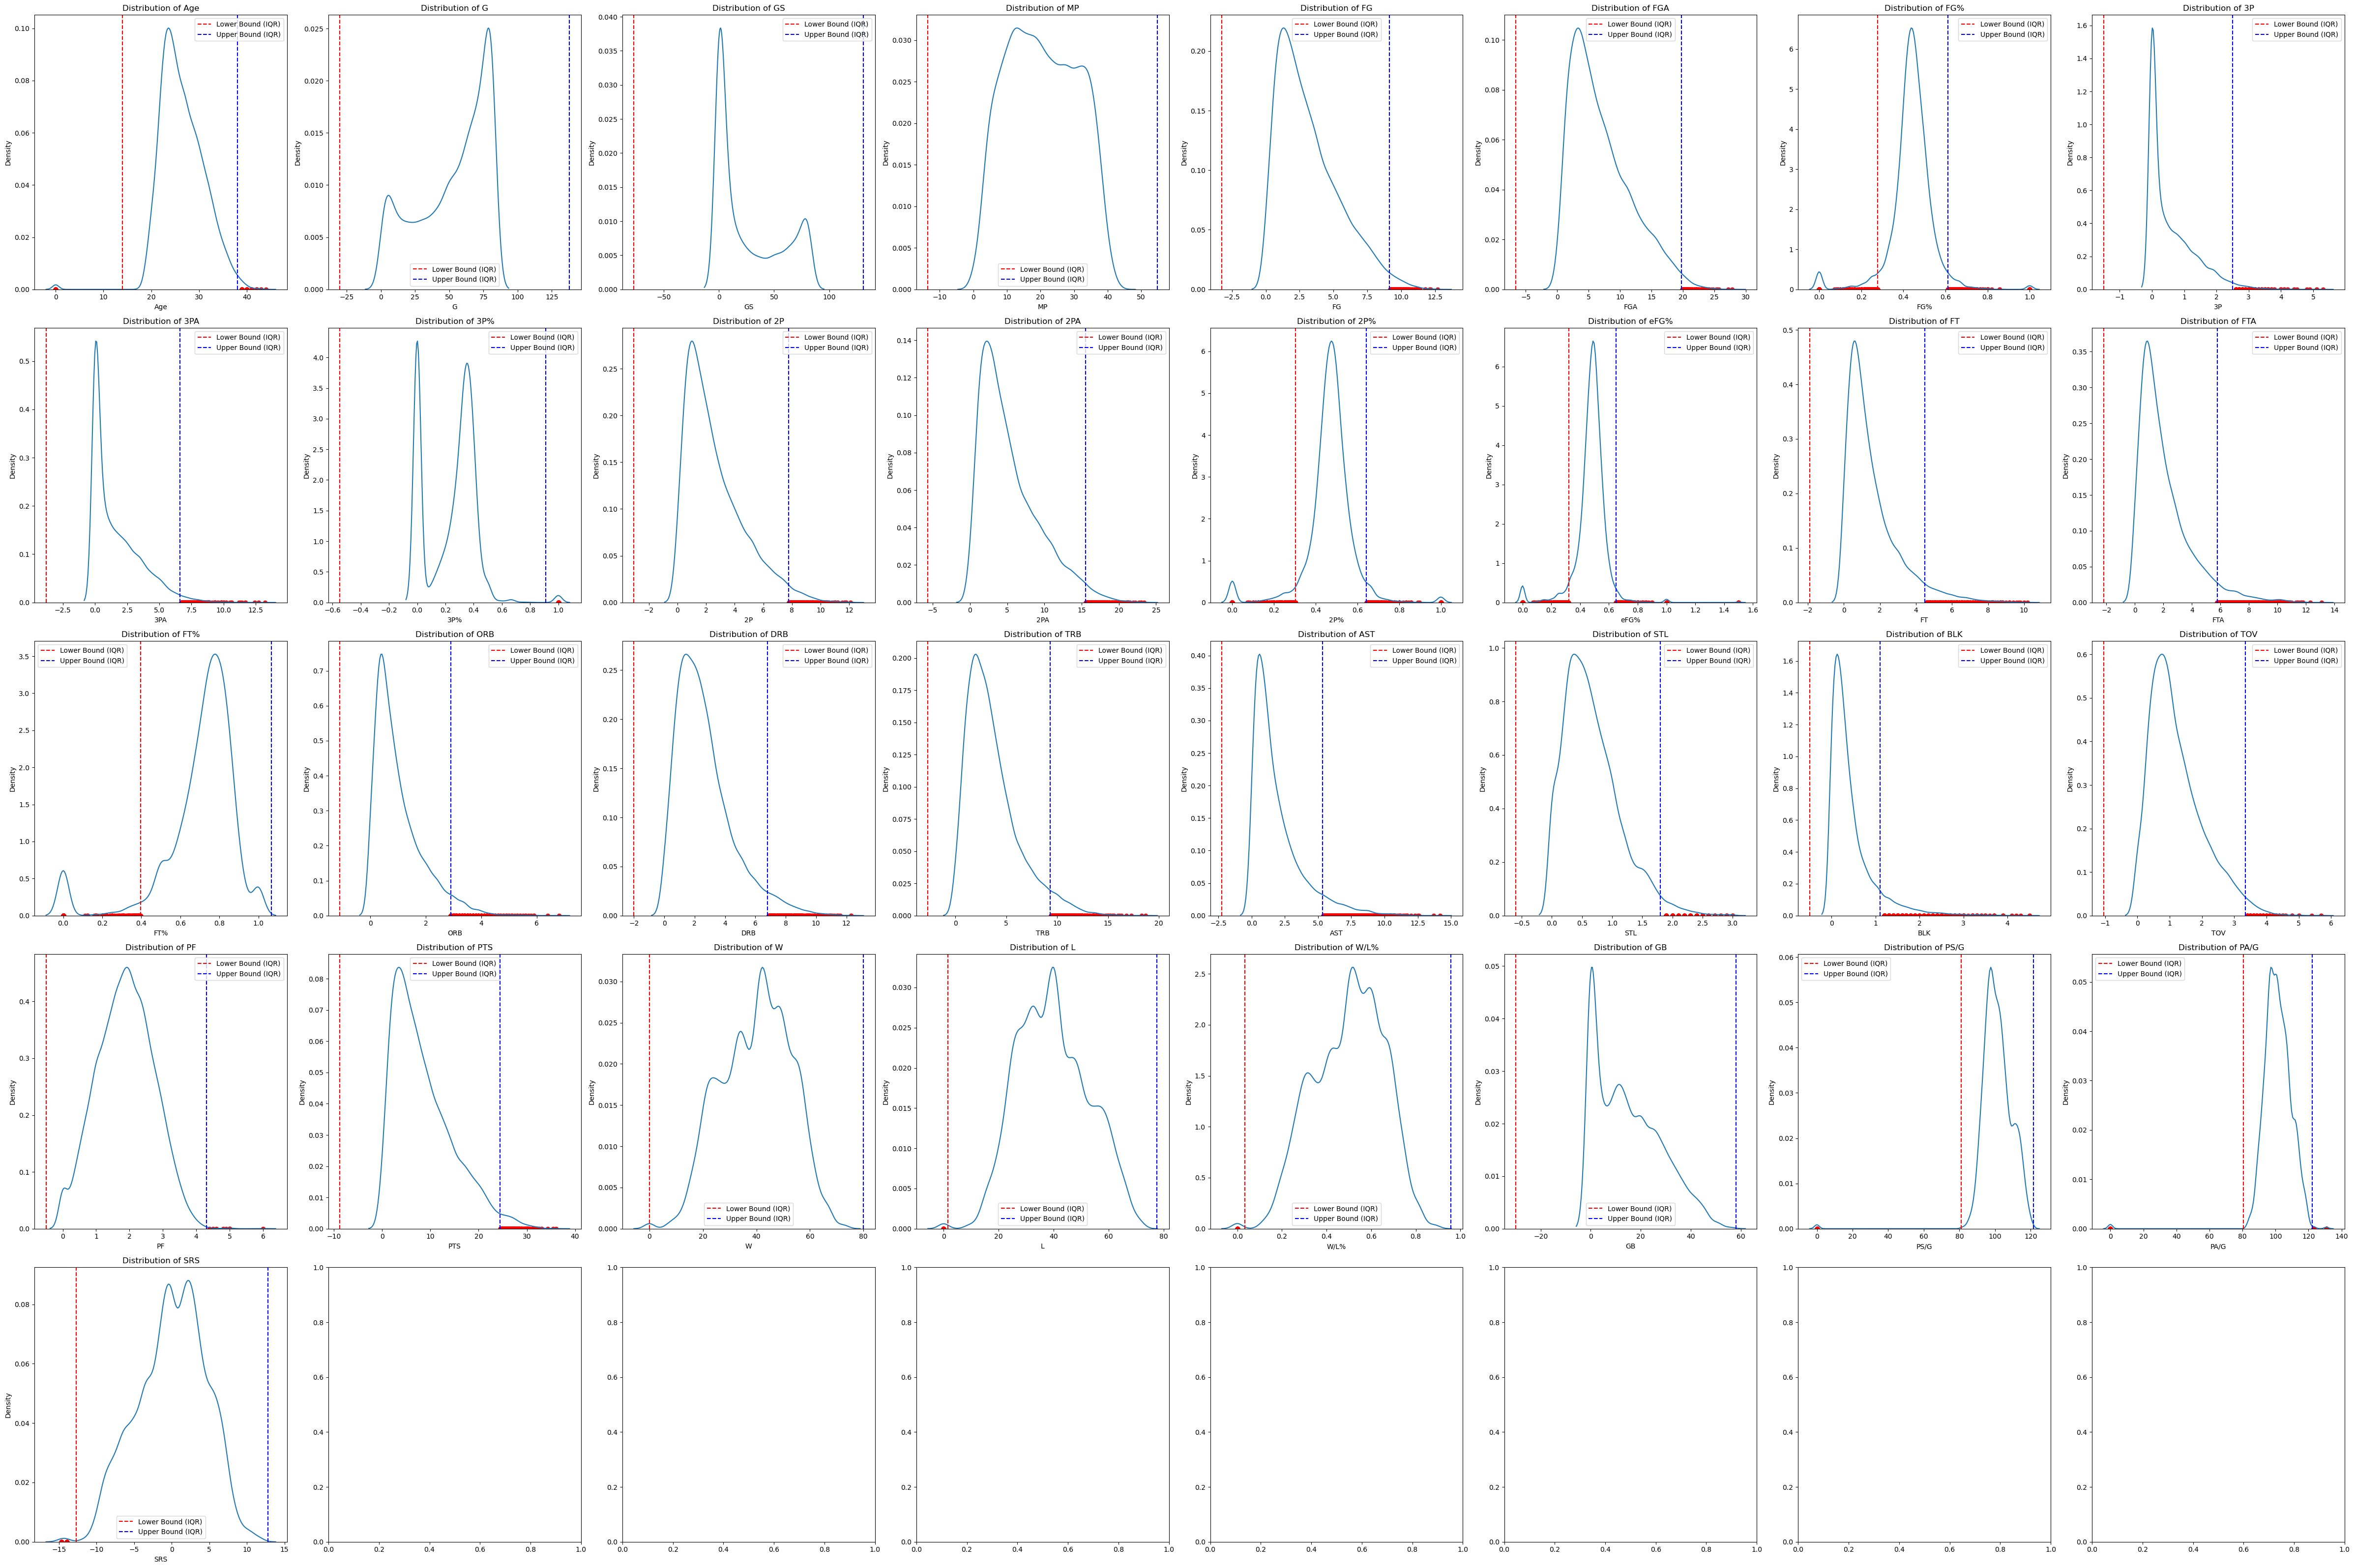

In [103]:
fig, ax = plt.subplots(nrows=5, ncols=8, figsize=(48, 32))
axes = ax.flatten()

for i, col in enumerate(X_train_num.columns):
    sns.kdeplot(X_train_num[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    

    q1 = np.percentile(X_train_num[col], 25)
    q3 = np.percentile(X_train_num[col], 75)
    iqr = q3 - q1
    

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr


    axes[i].axvline(lower_bound, color='red', linestyle='--', label='Lower Bound (IQR)')
    axes[i].axvline(upper_bound, color='blue', linestyle='--', label='Upper Bound (IQR)')
    
 
    outliers = X_train_num[(X_train_num[col] < lower_bound) | (X_train_num[col] > upper_bound)]
    axes[i].scatter(outliers[col], np.zeros_like(outliers[col]), color='red')

    axes[i].legend()

plt.tight_layout()
plt.show()

In [104]:
train[(train['3PA'] > 10.0)&(train['G']< 20)]

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS


In [105]:
train[(train['eFG%']>1.0)]

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
401,Jordan Sibert,26.0,Atlanta Hawks,SG,1.0,0.0,4.0,1.0,1.0,1.0,...,0.0,0.0,0.0,29.0,53.0,0.354,13.0,113.3,119.4,-6.06
3138,Tyson Wheeler,23.0,Denver Nuggets,PG,1.0,0.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,14.0,36.0,0.280,23.0,93.5,100.1,-6.67
4167,Dajuan Wagner,23.0,Golden State Warriors,SG,1.0,0.0,7.0,1.0,1.0,1.0,...,0.0,0.0,0.0,42.0,40.0,0.512,19.0,106.5,106.9,0.00
8029,Anthony Brown,25.0,Minnesota Timberwolves,SF,1.0,0.0,4.0,1.0,1.0,1.0,...,0.0,0.0,0.0,47.0,35.0,0.573,2.0,109.5,107.3,2.35
13299,Naz Mitrou-Long,24.0,Utah Jazz,SG,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,48.0,34.0,0.585,1.0,104.1,99.8,4.47


In [106]:
idx_to_drop = train[
    (train['3P%'] > 0.8) & (train['G']<20)

].index.tolist()

In [107]:
X_train_dropped = X_train.drop(index=idx_to_drop)
y_train_dropped = y_train.drop(index=idx_to_drop)

In [108]:
X_train_dropped.shape

(13484, 37)

In [109]:
len(idx_to_drop)

39

In [110]:
train.shape

(13523, 40)

In [111]:
X_train_num, X_train_cat = split_numerical_categorical(data=X_train_dropped,num_cols=num_column,cat_cols=cat_column)

Data num shape: (13484, 33)
Data cat shape: (13484, 1)


In [112]:
X_train_cat.isna().sum()

Pos    0
dtype: int64

In [113]:
def cat_OHE_encoder_fit(data):
    ''' 
    Fit a OneHotEncoder to the categorical data.

    Parameters

    data : pandas.DataFrame
    DataFrame containing categorical data to be encoded.

    Returns

    OneHotEncoder
    A fitted OneHotEncoder object, which can be used to transform the data
    '''
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(data)
    return encoder

def cat_OHE_encoder_transform(data, encoder):
    ''' 
    Parameters

    data : pandas.DataFrame
    DataFrame containing categorical data to be encoded.

    encoder : OneHotEncoder
    A fitted OneHotEncoder object used to encode the data.

    Returns

    pandas.DataFrame
    '''
    encoded_array = encoder.transform(data)
    feature_names = encoder.get_feature_names_out()
    cleaned_columns = [col.split('_')[-1] for col in feature_names]
    encoded_data = pd.DataFrame(encoded_array, columns=cleaned_columns, index=data.index)
    return encoded_data

In [114]:
ohe_data = X_train_cat
cat_ohe_encoder = cat_OHE_encoder_fit(ohe_data)
X_train_cat_ohe_encoded = cat_OHE_encoder_transform(ohe_data,cat_ohe_encoder)

In [115]:
def concat_data(num_data, cat_data):
    '''  
    Concatenates numerical and categorical data into a single DataFrame.

    This function ensures that the indices of the numerical and categorical data match before concatenation. If the indices do not match, the categorical data is reindexed to match the numerical data.

    Parameters:
    - num_data (pd.DataFrame): DataFrame containing numerical data.
    - cat_data (pd.DataFrame): DataFrame containing categorical data.

    Returns:
    - concatenated_data (pd.DataFrame): DataFrame with both numerical and categorical data concatenated along columns.
    '''
    if not num_data.index.equals(cat_data.index):
        cat_data = cat_data.reindex(num_data.index)
    concatenated_data = pd.concat([num_data, cat_data], axis=1)
    print(f'Numerical data shape  : {num_data.shape}')
    print(f'Categorical data shape: {cat_data.shape}')
    print(f'Concat data shape     : {concatenated_data.shape}')
    return concatenated_data

In [116]:
X_train_concat = concat_data(X_train_num,X_train_cat_ohe_encoded)

Numerical data shape  : (13484, 33)
Categorical data shape: (13484, 6)
Concat data shape     : (13484, 39)


In [117]:
X_train_concat.head()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,GB,PS/G,PA/G,SRS,0,C,PF,PG,SF,SG
0,29.0,79.0,79.0,32.7,5.6,12.9,0.435,1.1,3.3,0.336,...,18.0,109.8,109.0,0.72,0.0,0.0,0.0,1.0,0.0,0.0
1,31.0,81.0,81.0,38.0,9.5,20.2,0.470,1.0,3.1,0.341,...,18.0,109.8,109.0,0.72,0.0,0.0,0.0,0.0,1.0,0.0
2,25.0,78.0,2.0,14.9,2.2,4.6,0.489,0.0,0.0,0.667,...,18.0,109.8,109.0,0.72,0.0,0.0,0.0,0.0,1.0,0.0
3,23.0,4.0,0.0,2.3,0.0,0.0,0.000,0.0,0.0,0.000,...,18.0,109.8,109.0,0.72,0.0,1.0,0.0,0.0,0.0,0.0
4,28.0,79.0,2.0,23.6,5.0,10.9,0.461,0.2,0.6,0.286,...,18.0,109.8,109.0,0.72,0.0,0.0,0.0,0.0,0.0,1.0


In [118]:
def fit_scaler(data):
    '''  
    Fits a StandardScaler to the numerical data.

    This function computes the mean and standard deviation for each feature in the data to standardize them.

    Parameters:
    data (pd.DataFrame): DataFrame containing numerical data to be scaled.

    Returns:
    scaler (StandardScaler): A fitted StandardScaler object that can be used to transform the data.
    '''
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler
def transform_scaler(data, scaler):
    '''  
    Transforms the numerical data using a fitted StandardScaler.

    This function scales the data based on the mean and standard deviation computed by the fitted StandardScaler.

    Parameters:
    data (pd.DataFrame): DataFrame containing numerical data to be scaled.
    scaler (StandardScaler): A fitted StandardScaler object used for scaling the data.

    Returns:
    scaled_data (pd.DataFrame): DataFrame containing the scaled numerical data.
    '''
    scaled_array = scaler.transform(data)
    scaled_data = pd.DataFrame(scaled_array, index=data.index, columns=data.columns)
    return scaled_data

In [119]:
scaler = fit_scaler(X_train_concat)
X_train_clean = transform_scaler(X_train_concat, scaler)

In [120]:
X_train_clean.shape

(13484, 39)

In [121]:
X_train_num.columns

Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'W', 'L', 'W/L%', 'GB', 'PS/G',
       'PA/G', 'SRS'],
      dtype='object')

In [122]:
def preprocess_data(data, num_cols, cat_cols, cat_ohe_encoder, scaler):
    # Filter columns to only those present in data
    num_cols = [col for col in num_cols if col in data.columns]
    cat_cols = [col for col in cat_cols if col in data.columns]
    
    if not num_cols:
        print("Warning: No numerical columns found.")
    if not cat_cols:
        print("Warning: No categorical columns found.")
    
    num_data = data[num_cols]
    cat_data = data[cat_cols]
    
    cat_ohe_data_encoded = cat_OHE_encoder_transform(cat_data, cat_ohe_encoder)
    
    processed_data = concat_data(num_data, cat_ohe_data_encoded)
    print(f"Original data shape: {processed_data.shape}")
    
    clean_data = transform_scaler(processed_data, scaler)
    print(f"Mapped data shape: {clean_data.shape}")
    
    return clean_data


In [123]:
X_train_clean = preprocess_data(
    data=X_train_dropped, 
    num_cols=num_column, 
    cat_cols=cat_column, 
    cat_ohe_encoder = cat_ohe_encoder,
    scaler=scaler
)

Numerical data shape  : (13484, 33)
Categorical data shape: (13484, 6)
Concat data shape     : (13484, 39)
Original data shape: (13484, 39)
Mapped data shape: (13484, 39)


In [124]:
y_train_dropped.shape

(13484,)

In [125]:
X_test_clean = preprocess_data(
    data=X_test, 
    num_cols=num_column, 
    cat_cols=cat_column, 
    cat_ohe_encoder = cat_ohe_encoder,
    scaler=scaler
)

Numerical data shape  : (495, 33)
Categorical data shape: (495, 6)
Concat data shape     : (495, 39)
Original data shape: (495, 39)
Mapped data shape: (495, 39)


In [126]:
def extract_cv_results(cv_obj):

    best_train_score = -cv_obj.cv_results_['mean_train_score'][cv_obj.best_index_]

    best_valid_score = -cv_obj.best_score_  
    
    best_params = cv_obj.best_params_
    
    return best_train_score, best_valid_score, best_params

In [127]:
tscv = TimeSeriesSplit(n_splits=5)

In [128]:
pcas = PCA(n_components=0.95)
X_train_pca = pcas.fit_transform(X_train_clean)
X_test_pca = pcas.transform(X_test_clean)

In [129]:
param_grid_base = {'strategy': ['mean']}
baseline_model = DummyRegressor()
reg_base = GridSearchCV(baseline_model, param_grid_base, scoring='neg_root_mean_squared_error', cv=tscv,return_train_score=True)
reg_base.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DummyRegressor(), param_grid={'strategy': ['mean']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [130]:
train_base, valid_base, best_param_base = extract_cv_results(reg_base)

print(f'Train score - Baseline model: {train_base}')
print(f'Valid score - Baseline model: {valid_base}')
print(f'Best Params - Baseline model: {best_param_base}')

Train score - Baseline model: 0.062201729379921335
Valid score - Baseline model: 0.06170944284288955
Best Params - Baseline model: {'strategy': 'mean'}


In [131]:
param_grid_base_pca = {'strategy': ['mean']}
baseline_model_pca = DummyRegressor()
reg_base_pca = GridSearchCV(baseline_model_pca, param_grid_base_pca, scoring='neg_root_mean_squared_error', cv=tscv,return_train_score=True)
reg_base_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DummyRegressor(), param_grid={'strategy': ['mean']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [132]:
train_base_pca, valid_base_pca, best_param_base_pca = extract_cv_results(reg_base_pca)

print(f'Train score - Baseline model: {train_base_pca}')
print(f'Valid score - Baseline model: {valid_base_pca}')
print(f'Best Params - Baseline model: {best_param_base_pca}')

Train score - Baseline model: 0.062201729379921335
Valid score - Baseline model: 0.06170944284288955
Best Params - Baseline model: {'strategy': 'mean'}


In [133]:
param_grid_ridge = {
    'alpha': np.logspace(-6, 10, 100)  # Regularization strength from 10^-6 to 10^10
}
ridge = Ridge()
reg_ridge = GridSearchCV(ridge, param_grid_ridge, scoring='neg_root_mean_squared_error', cv=tscv,return_train_score=True)
reg_ridge.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.83073828...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [134]:
train_ridge, valid_ridge, best_param_ridge = extract_cv_results(reg_ridge)

print(f'Train score - Ridge model: {train_ridge}')
print(f'Valid score - Ridge model: {valid_ridge} ')
print(f'Best Params - Ridge model: {best_param_ridge}')

Train score - Ridge model: 0.054957988230925695
Valid score - Ridge model: 0.0556161082122973 
Best Params - Ridge model: {'alpha': 39.44206059437664}


In [135]:
param_grid_ridge_pca = {
    'alpha': np.logspace(-6, 10, 100)  # Regularization strength from 10^-6 to 10^10
}
ridge = Ridge()
reg_ridge_pca = GridSearchCV(ridge, param_grid_ridge, scoring='neg_root_mean_squared_error', cv=tscv,return_train_score=True)
reg_ridge_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.83073828...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [136]:
train_ridge_pca, valid_ridge_pca, best_param_ridge_pca = extract_cv_results(reg_ridge_pca)

print(f'Train score - Ridge model: {train_ridge_pca}')
print(f'Valid score - Ridge model: {valid_ridge_pca} ')
print(f'Best Params - Ridge model: {best_param_ridge_pca}')

Train score - Ridge model: 0.058083936773413135
Valid score - Ridge model: 0.05750098660581131 
Best Params - Ridge model: {'alpha': 1629.7508346206469}


In [137]:
param_grid_lasso = {
    'alpha':np.logspace(-6, 10, 100)
}


lasso = Lasso()

reg_lasso = GridSearchCV(lasso, param_grid_lasso, cv=tscv,scoring='neg_root_mean_squared_error', return_train_score=True)
reg_lasso.fit(X_train_clean, y_train_dropped)

C:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.888e+00, tolerance: 8.512e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.709e+00, tolerance: 1.644e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.474e+00, toleranc

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.83073828...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [138]:
train_lasso, valid_lasso, best_param_lasso = extract_cv_results(reg_lasso)

print(f'Train score - Lasso model: {train_lasso}')
print(f'Valid score - Lasso model: {valid_lasso}')
print(f'Best Params - Lasso model: {best_param_lasso}')

Train score - Lasso model: 0.05492889862500192
Valid score - Lasso model: 0.05560447102224111
Best Params - Lasso model: {'alpha': 0.0001261856883066021}


In [139]:
param_grid_lasso_pca = {
    'alpha':np.logspace(-6, 10, 100)
}


lasso = Lasso()

reg_lasso_pca = GridSearchCV(lasso, param_grid_lasso, cv=tscv,scoring='neg_root_mean_squared_error', return_train_score=True)
reg_lasso_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.83073828...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [140]:
train_lasso_pca, valid_lasso_pca, best_param_lasso_pca = extract_cv_results(reg_lasso_pca)

print(f'Train score - Lasso model: {train_lasso_pca}')
print(f'Valid score - Lasso model: {valid_lasso_pca}')
print(f'Best Params - Lasso model: {best_param_lasso_pca}')

Train score - Lasso model: 0.057950885906415596
Valid score - Lasso model: 0.057630011433560856
Best Params - Lasso model: {'alpha': 0.0005590810182512228}


In [141]:
param_grid = {'alpha':np.logspace(-6, 10, 100),
            'l1_ratio':[0.01,0.1,1]}
elastic_net_model = ElasticNet()
reg_elastic = GridSearchCV(elastic_net_model, param_grid,cv=tscv,scoring='neg_root_mean_squared_error',return_train_score=True)
reg_elastic.fit(X_train_clean, y_train_dropped)

C:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.312e+00, tolerance: 8.512e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.458e+00, tolerance: 1.644e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.001e+01, toleranc

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.830...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10]),
                         'l1_ratio': [0.01, 0.1, 1]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [142]:
train_elastic, valid_elastic, best_param_elastic = extract_cv_results(reg_elastic)

print(f'Train score - elastic model: {train_elastic}')
print(f'Valid score - elastic model: {valid_elastic}')
print(f'Best Params - elastic model: {best_param_elastic}')

Train score - elastic model: 0.05502673496107093
Valid score - elastic model: 0.05551588603654377
Best Params - elastic model: {'alpha': 0.007564633275546291, 'l1_ratio': 0.01}


In [143]:
param_grid = {'alpha':np.logspace(-6, 10, 100),
            'l1_ratio':[0.01,0.1,1]}
elastic_net_model = ElasticNet()
reg_elastic_pca = GridSearchCV(elastic_net_model, param_grid,scoring='neg_root_mean_squared_error',cv=tscv,return_train_score=True)
reg_elastic_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-06, 1.45082878e-06, 2.10490414e-06, 3.05385551e-06,
       4.43062146e-06, 6.42807312e-06, 9.32603347e-06, 1.35304777e-05,
       1.96304065e-05, 2.84803587e-05, 4.13201240e-05, 5.99484250e-05,
       8.69749003e-05, 1.26185688e-04, 1.830...
       8.49753436e+06, 1.23284674e+07, 1.78864953e+07, 2.59502421e+07,
       3.76493581e+07, 5.46227722e+07, 7.92482898e+07, 1.14975700e+08,
       1.66810054e+08, 2.42012826e+08, 3.51119173e+08, 5.09413801e+08,
       7.39072203e+08, 1.07226722e+09, 1.55567614e+09, 2.25701972e+09,
       3.27454916e+09, 4.75081016e+09, 6.89261210e+09, 1.00000000e+10]),
                         'l1_ratio': [0.01, 0.1, 1]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [144]:
train_elastic_pca, valid_elastic_pca, best_param_elastic_pca = extract_cv_results(reg_elastic_pca)

print(f'Train score - elastic model: {train_elastic_pca}')
print(f'Valid score - elastic model: {valid_elastic_pca}')
print(f'Best Params - elastic model: {best_param_elastic_pca}')

Train score - elastic model: 0.05797150246318281
Valid score - elastic model: 0.05759870510960104
Best Params - elastic model: {'alpha': 0.04862601580065353, 'l1_ratio': 0.01}


In [145]:
param_grid = {
       'n_estimators': [133, 135, 137],
       'max_depth': [53,55, 57],
       'min_samples_split': [3,4],
       'min_samples_leaf': [3,4],
       'bootstrap': [True],
       'oob_score': [True]
   }

rfg = RandomForestRegressor(random_state=42)
grid_rfg = GridSearchCV(rfg, param_grid, cv=tscv, n_jobs=-1, 
                        return_train_score=True,
                        scoring='neg_root_mean_squared_error')
grid_rfg.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [53, 55, 57],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [3, 4],
                         'n_estimators': [133, 135, 137], 'oob_score': [True]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [146]:
train_rf, valid_rf, best_param_rf = extract_cv_results(grid_rfg)

print(f'Train score - Random Forest model: {train_rf}')
print(f'Valid score - Random Forest model: {valid_rf}')
print(f'Best Params - Random Forest model: {best_param_rf}')

Train score - Random Forest model: 0.022300971256744462
Valid score - Random Forest model: 0.044927402385466275
Best Params - Random Forest model: {'bootstrap': True, 'max_depth': 53, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 133, 'oob_score': True}


In [147]:
param_grid_pca = {
    'n_estimators': [133, 135, 137],
    'max_depth': [53, 55, 57],
    'min_samples_split': [3, 4],
    'min_samples_leaf': [3, 4],
    'bootstrap': [True],
    'oob_score': [True]
}

rfg_pca = RandomForestRegressor(random_state=42)
grid_rfg_pca = GridSearchCV(rfg_pca, param_grid_pca, cv=tscv, n_jobs=-1, 
                            return_train_score=True,
                            scoring='neg_root_mean_squared_error')
grid_rfg_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [53, 55, 57],
                         'min_samples_leaf': [3, 4],
                         'min_samples_split': [3, 4],
                         'n_estimators': [133, 135, 137], 'oob_score': [True]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [148]:
train_rf_pca, valid_rf_pca, best_param_rf_pca = extract_cv_results(grid_rfg_pca)

print(f'Train score - Random Forest model: {train_rf_pca}')
print(f'Valid score - Random Forest model: {valid_rf_pca}')
print(f'Best Params - Random Forest model: {best_param_rf_pca}')

Train score - Random Forest model: 0.021934463377853354
Valid score - Random Forest model: 0.039515449168135305
Best Params - Random Forest model: {'bootstrap': True, 'max_depth': 53, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 133, 'oob_score': True}


In [149]:
param_grid = {'C': [0.01,0.1,1,10],
            'kernel': ['linear','poly', 'sigmoid'],
            'gamma': ['auto'],
            'degree': [2,3,4],
            'epsilon': [0.1,0.5,1]}
svr_model = SVR()
reg_svm = GridSearchCV(svr_model, param_grid,return_train_score=True,cv=tscv,scoring='neg_root_mean_squared_error')
reg_svm.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'degree': [2, 3, 4],
                         'epsilon': [0.1, 0.5, 1], 'gamma': ['auto'],
                         'kernel': ['linear', 'poly', 'sigmoid']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [150]:
train_svr, valid_svr, best_param_svr = extract_cv_results(reg_svm)

print(f'Train score - SVM model: {train_svr}')
print(f'Valid score - SVM model: {valid_svr}')
print(f'Best Params - SVM model: {best_param_svr}')

Train score - SVM model: 0.05988907507959969
Valid score - SVM model: 0.06154492838703311
Best Params - SVM model: {'C': 0.01, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}


In [151]:
param_grid_pca = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'sigmoid'],
    'gamma': ['auto'],
    'degree': [2, 3, 4],
    'epsilon': [0.1, 0.5, 1]
}

svr_model_pca = SVR()
reg_svm_pca = GridSearchCV(svr_model_pca, param_grid_pca, cv=tscv,return_train_score=True, scoring='neg_root_mean_squared_error')
reg_svm_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'degree': [2, 3, 4],
                         'epsilon': [0.1, 0.5, 1], 'gamma': ['auto'],
                         'kernel': ['linear', 'poly', 'sigmoid']},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [152]:
train_svr_pca, valid_svr_pca, best_param_svr_pca = extract_cv_results(reg_svm_pca)

print(f'Train score - SVM model: {train_svr_pca}')
print(f'Valid score - SVM model: {valid_svr_pca}')
print(f'Best Params - SVM model: {best_param_svr_pca}')

Train score - SVM model: 0.06536890040970138
Valid score - SVM model: 0.06911330925464101
Best Params - SVM model: {'C': 0.01, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'linear'}


In [153]:
param_grid = {'n_estimators': [25, 55],
            'learning_rate': [0.01, 0.1, 1],
            'max_depth': [3, 5]}
gb_model = GradientBoostingRegressor()
grid_gb = GridSearchCV(gb_model, param_grid,return_train_score=True,cv=tscv,scoring='neg_root_mean_squared_error')
grid_gb.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5],
                         'n_estimators': [25, 55]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [154]:
train_gb, valid_gb, best_param_gb = extract_cv_results(grid_gb)

print(f'Train score - Decision Tree model: {train_gb}')
print(f'Valid score - Decision Tree model: {valid_gb}')
print(f'Best Params - Decision Tree model: {best_param_gb}')

Train score - Decision Tree model: 0.015139074193144201
Valid score - Decision Tree model: 0.0440161421360204
Best Params - Decision Tree model: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 55}


In [155]:
param_grid_pca = {'n_estimators': [25,55],
            'learning_rate': [0.1,1],
            'max_depth': [3,5]}
gb_model_pca = GradientBoostingRegressor()
grid_gb_pca = GridSearchCV(gb_model_pca, param_grid_pca,return_train_score=True,cv=tscv,scoring='neg_root_mean_squared_error')
grid_gb_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 1], 'max_depth': [3, 5],
                         'n_estimators': [25, 55]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [156]:
train_gb_pca, valid_gb_pca, best_param_gb_pca = extract_cv_results(grid_gb_pca)

print(f'Train score - Decision Tree model: {train_gb_pca}')
print(f'Valid score - Decision Tree model: {valid_gb_pca}')
print(f'Best Params - Decision Tree model: {best_param_gb_pca}')

Train score - Decision Tree model: 0.017572884843678912
Valid score - Decision Tree model: 0.041426932931516565
Best Params - Decision Tree model: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 55}


In [157]:
base_dt = DecisionTreeRegressor(max_depth=3, random_state=42)

adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.01, 0.1, 1]
}

grid_ada = GridSearchCV(adaboost_model, param_grid, scoring='neg_root_mean_squared_error', cv=tscv, return_train_score=True)

grid_ada.fit(X_train_clean, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=AdaBoostRegressor(learning_rate=0.1, n_estimators=100,
                                         random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [158]:
train_ada_dt, valid_ada_dt, best_param_ada_dt = extract_cv_results(grid_ada)

print(f'Train score - Decision Tree model: {train_ada_dt}')
print(f'Valid score - Decision Tree model: {valid_ada_dt}')
print(f'Best Params - Decision Tree model: {best_param_ada_dt}')

Train score - Decision Tree model: 0.023976869199333707
Valid score - Decision Tree model: 0.04730905679953543
Best Params - Decision Tree model: {'learning_rate': 0.1, 'n_estimators': 200}


In [159]:
base_dt_pca = DecisionTreeRegressor(max_depth=3, random_state=42)

adaboost_model_pca = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

param_grid_pca = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.01, 0.1, 1]
}

grid_ada_pca = GridSearchCV(adaboost_model_pca, param_grid_pca, scoring='neg_root_mean_squared_error', cv=tscv, return_train_score=True)

grid_ada_pca.fit(X_train_pca, y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=AdaBoostRegressor(learning_rate=0.1, n_estimators=100,
                                         random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [160]:
train_ada_dt_pca, valid_ada_dt_pca, best_param_ada_dt_pca = extract_cv_results(grid_ada_pca)

print(f'Train score - Decision Tree model: {train_ada_dt_pca}')
print(f'Valid score - Decision Tree model: {valid_ada_dt_pca}')
print(f'Best Params - Decision Tree model: {best_param_ada_dt_pca}')

Train score - Decision Tree model: 0.026488752881546833
Valid score - Decision Tree model: 0.04216665460761915
Best Params - Decision Tree model: {'learning_rate': 0.01, 'n_estimators': 200}


In [161]:
X_train_array = X_train_clean.to_numpy()

In [162]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [163]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(objective='reg:squarederror', random_state=42)

xgboost_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1],
    "gamma": [0.1, 1.0],
    "max_depth": [5, 10]
}

xgboost_reg = GridSearchCV(estimator=xgboost,
                           param_grid=xgboost_param_grid,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True,
                           cv=tscv)

xgboost_reg.fit(X=X_train_array, y=y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'gamma': [0.1, 1.0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [164]:
train_xgboost, valid_xgboost, best_param_xgboost = extract_cv_results(xgboost_reg)

print(f'Train score - Decision Tree model: {train_xgboost}')
print(f'Valid score - Decision Tree model: {valid_xgboost}')
print(f'Best Params - Decision Tree model: {best_param_xgboost}')

Train score - Decision Tree model: 0.02117347609755838
Valid score - Decision Tree model: 0.04871345006172027
Best Params - Decision Tree model: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


In [165]:
xgboost_pca = XGBRegressor(objective='reg:squarederror', random_state=42)

xgboost_param_grid_pca = {
    "n_estimators": [100, 200, 300],
    "eta": [0.01, 0.1], 
    "gamma": [0.1, 1.0],
    "max_depth": [5, 10]
}


xgboost_reg_pca = GridSearchCV(estimator=xgboost,
                      param_grid=xgboost_param_grid,
                      scoring='neg_root_mean_squared_error',
                      return_train_score=True,cv=tscv)
xgboost_reg_pca.fit(X= X_train_pca, y= y_train_dropped)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'gamma': [0.1, 1.0], 'learning_rate': [0.01, 0.1],
                         'max_depth': [5, 10],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [166]:
train_xgboost_pca, valid_xgboost_pca, best_param_xgboost_pca = extract_cv_results(xgboost_reg_pca)

print(f'Train score - Decision Tree model: {train_xgboost_pca}')
print(f'Valid score - Decision Tree model: {valid_xgboost_pca}')
print(f'Best Params - Decision Tree model: {best_param_xgboost_pca}')

Train score - Decision Tree model: 0.02375408372131198
Valid score - Decision Tree model: 0.042037065720290374
Best Params - Decision Tree model: {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}


In [167]:
summary_df = pd.DataFrame(
    data={
        'model': [
                  'Baseline', 'Baseline_PCA', 'Ridge', 'Ridge_PCA', 'Lasso',
                  'Lasso_PCA', 'ElasticNet', 'ElasticNet_PCA', 'XGB', 'XGB_PCA',
                  'Adaboost DT', 'Adaboost DT_PCA', 'Gradient Boosting', 'Gradient Boosting_PCA',
                  'Random Forest', 'Random Forest_PCA'
                  ],
        'train_score': [
                        train_base, train_base_pca, train_ridge, train_ridge_pca,train_lasso,
                        train_lasso_pca, train_elastic,train_elastic_pca,train_xgboost,train_xgboost_pca,
                        train_ada_dt, train_ada_dt_pca, train_gb, train_gb_pca, train_rf, train_rf_pca
                        ],
        'valid_score': [
                        valid_base, valid_base_pca, valid_ridge,valid_ridge_pca, valid_lasso,
                        valid_lasso_pca, valid_elastic, valid_elastic_pca, valid_xgboost, valid_xgboost_pca,
                        valid_ada_dt, valid_ada_dt_pca, valid_gb, valid_gb_pca, valid_rf, valid_rf_pca 
                        ],
        'best_params': [
                        best_param_base, best_param_base_pca, best_param_ridge, best_param_ridge_pca,best_param_lasso,
                        best_param_lasso_pca, best_param_elastic, best_param_elastic_pca, best_param_xgboost, best_param_xgboost_pca,
                        best_param_ada_dt, best_param_ada_dt_pca, best_param_gb, best_param_gb_pca, best_param_rf, best_param_rf_pca 
                        ]
    }
)

summary_df['train_score'] 
summary_df['valid_score']
summary_df.sort_values(by='valid_score', ascending=True)

,model,train_score,valid_score,best_params
15,Random Forest_PCA,0.021934,0.039515,"{'bootstrap': True, 'max_depth': 53, 'min_samp..."
13,Gradient Boosting_PCA,0.017573,0.041427,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
9,XGB_PCA,0.023754,0.042037,"{'gamma': 0.1, 'learning_rate': 0.01, 'max_dep..."
11,Adaboost DT_PCA,0.026489,0.042167,"{'learning_rate': 0.01, 'n_estimators': 200}"
12,Gradient Boosting,0.015139,0.044016,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
14,Random Forest,0.022301,0.044927,"{'bootstrap': True, 'max_depth': 53, 'min_samp..."
10,Adaboost DT,0.023977,0.047309,"{'learning_rate': 0.1, 'n_estimators': 200}"
8,XGB,0.021173,0.048713,"{'gamma': 0.1, 'learning_rate': 0.01, 'max_dep..."
6,ElasticNet,0.055027,0.055516,"{'alpha': 0.007564633275546291, 'l1_ratio': 0.01}"
4,Lasso,0.054929,0.055604,{'alpha': 0.0001261856883066021}


In [168]:
def calculate_map_k(models, test_sets, y_test, k=5):
    results = {}

    for model_name, model_data in models.items():
        model = model_data['model']
        test_key = model_data['test_set']
        X_test = test_sets[test_key]

        if 'XGB' in model_name and isinstance(X_test, pd.DataFrame):
            X_test = X_test.to_numpy()

        predictions = model.predict(X_test)
        predictions = pd.DataFrame(predictions, columns=['predictions'], index=y_test.index)
        
        combination = pd.concat([y_test, predictions], axis=1)
        
        actual = combination.sort_values('Share', ascending=False)
        actual['Rk'] = range(1, len(actual) + 1)
        
        predicted = combination.sort_values('predictions', ascending=False)
        predicted['Rk_predicted'] = range(1, len(predicted) + 1)
        
        comb = pd.merge(actual, predicted[['Rk_predicted']], left_index=True, right_index=True)
        comb.sort_values('Rk', inplace=True)
        
        rmse = mean_squared_error(comb['Share'], comb['predictions'], squared=False)
        
        def apk(actual_rank, predicted_rank, k=5):
            if actual_rank > k:
                return 0
            return max(0, 1 - (abs(actual_rank - predicted_rank) / k))
        
        map_k_scores = [apk(row['Rk'], row['Rk_predicted'], k) for _, row in comb.iterrows()]
        map_k_score = np.mean(map_k_scores)
        
        results[(model_name, test_key)] = {'MAP@K': map_k_score, 'RMSE': rmse}

    return results

In [169]:
def results_to_dataframe(results):
    results_list = [
        {
            'Model': model_name,
            'Test Set': test_name,
            'MAP@K': scores['MAP@K'],
            'RMSE': scores['RMSE']
        }
        for (model_name, test_name), scores in results.items()
    ]
    df_results = pd.DataFrame(results_list)

    df_results_sorted = df_results.sort_values(by=['MAP@K', 'RMSE'], ascending=[False, True])
    
    return df_results_sorted

In [170]:
models = {
    'Base Model': {'model': reg_base, 'test_set': 'UsualTest'},
    'Base Model_PCA': {'model': reg_base_pca, 'test_set': 'PCATest'},
    'Ridge': {'model': reg_ridge, 'test_set': 'UsualTest'},
    'Ridge_PCA': {'model': reg_ridge_pca, 'test_set': 'PCATest'},
    'Lasso': {'model': reg_lasso, 'test_set': 'UsualTest'},
    'Lasso_PCA': {'model': reg_lasso_pca, 'test_set': 'PCATest'},
    'ElasticNet': {'model': reg_elastic, 'test_set': 'UsualTest'},
    'ElasticNet_PCA': {'model': reg_elastic_pca, 'test_set': 'PCATest'},
    'XGB': {'model': xgboost_reg, 'test_set': 'UsualTest'},
    'XGB_PCA': {'model': xgboost_reg_pca, 'test_set': 'PCATest'},
    'Adaboost': {'model': grid_ada, 'test_set': 'UsualTest'},
    'Adaboosst_PCA': {'model': grid_ada_pca, 'test_set': 'PCATest'},
    'Gradient Boosting': {'model': grid_gb, 'test_set': 'UsualTest'},
    'Gradient Boosting': {'model': grid_gb_pca, 'test_set': 'PCATest'},
    'RandomForest': {'model': grid_rfg, 'test_set': 'UsualTest'},
    'RandomForest_PCA': {'model': grid_rfg_pca, 'test_set': 'PCATest'},
}

test_sets = {
    'UsualTest': X_test_clean,
    'PCATest': X_test_pca,
}

y_test = test[['Player', 'Share', 'Year']]

results = calculate_map_k(models, test_sets, y_test, k=5)

C:\Users\matth\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\matth\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\matth\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\matth\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

In [171]:
df_results_sorted = results_to_dataframe(results)
print(df_results_sorted)

                Model   Test Set     MAP@K      RMSE
8                 XGB  UsualTest  0.007677  0.031351
14   RandomForest_PCA    PCATest  0.007273  0.029964
9             XGB_PCA    PCATest  0.006869  0.029802
11      Adaboosst_PCA    PCATest  0.006869  0.041514
12  Gradient Boosting    PCATest  0.006465  0.034760
13       RandomForest  UsualTest  0.006465  0.037445
10           Adaboost  UsualTest  0.006465  0.052322
6          ElasticNet  UsualTest  0.004848  0.053423
3           Ridge_PCA    PCATest  0.004848  0.055500
2               Ridge  UsualTest  0.004444  0.053349
4               Lasso  UsualTest  0.004444  0.053460
7      ElasticNet_PCA    PCATest  0.004444  0.055491
5           Lasso_PCA    PCATest  0.004444  0.055570
0          Base Model  UsualTest  0.000000  0.058113
1      Base Model_PCA    PCATest  0.000000  0.058113


In [172]:
X_test_array = X_test_clean.to_numpy()

In [173]:
prediction = xgboost_reg.predict(X_test_array)

In [174]:
prediction = pd.DataFrame(prediction, columns=['predictions'], index=test.index)

In [175]:
combination = pd.concat([test[['Player', 'Share','Year']], prediction], axis=1)

In [176]:
combination.sort_values('Share',ascending=False).head(9)

,Player,Share,Year,predictions
3473,Nikola Jokić,0.935,2024,0.688550
9437,Shai Gilgeous-Alexander,0.646,2024,0.643342
3010,Luka Dončić,0.572,2024,0.344233
7649,Giannis Antetokounmpo,0.194,2024,0.450844
9188,Jalen Brunson,0.143,2024,0.156716
956,Jayson Tatum,0.087,2024,0.292501
8111,Anthony Edwards,0.018,2024,0.087079
11750,Domantas Sabonis,0.003,2024,0.017784
10835,Kevin Durant,0.001,2024,0.200246


In [177]:
mean_squared_error(combination['Share'],combination['predictions'])

0.0009828772552195816

In [178]:
actual = combination.sort_values('Share', ascending=False)

In [179]:
actual['Rk'] = list(range(1, combination.shape[0]+1))

In [180]:
actual.head(9)

,Player,Share,Year,predictions,Rk
3473,Nikola Jokić,0.935,2024,0.688550,1
9437,Shai Gilgeous-Alexander,0.646,2024,0.643342,2
3010,Luka Dončić,0.572,2024,0.344233,3
7649,Giannis Antetokounmpo,0.194,2024,0.450844,4
9188,Jalen Brunson,0.143,2024,0.156716,5
956,Jayson Tatum,0.087,2024,0.292501,6
8111,Anthony Edwards,0.018,2024,0.087079,7
11750,Domantas Sabonis,0.003,2024,0.017784,8
10835,Kevin Durant,0.001,2024,0.200246,9


In [181]:
predicted= combination.sort_values('predictions', ascending=False)

In [182]:
predicted['Rk_predicted'] = list(range(1, combination.shape[0]+1))

In [183]:
predicted.head(9)

,Player,Share,Year,predictions,Rk_predicted
3473,Nikola Jokić,0.935,2024,0.688550,1
9437,Shai Gilgeous-Alexander,0.646,2024,0.643342,2
7649,Giannis Antetokounmpo,0.194,2024,0.450844,3
10374,Joel Embiid,0.000,2024,0.392412,4
3010,Luka Dončić,0.572,2024,0.344233,5
956,Jayson Tatum,0.087,2024,0.292501,6
10835,Kevin Durant,0.001,2024,0.200246,7
9188,Jalen Brunson,0.143,2024,0.156716,8
6350,Anthony Davis,0.000,2024,0.108688,9


In [184]:
comb = pd.concat([actual, predicted['Rk_predicted']], axis=1)

In [185]:
comb.sort_values('Rk').head(9)

,Player,Share,Year,predictions,Rk,Rk_predicted
3473,Nikola Jokić,0.935,2024,0.688550,1,1
9437,Shai Gilgeous-Alexander,0.646,2024,0.643342,2,2
3010,Luka Dončić,0.572,2024,0.344233,3,5
7649,Giannis Antetokounmpo,0.194,2024,0.450844,4,3
9188,Jalen Brunson,0.143,2024,0.156716,5,8
956,Jayson Tatum,0.087,2024,0.292501,6,6
8111,Anthony Edwards,0.018,2024,0.087079,7,13
11750,Domantas Sabonis,0.003,2024,0.017784,8,22
10835,Kevin Durant,0.001,2024,0.200246,9,7


In [186]:
explainer = shap.Explainer(grid_rfg.predict, X_test_clean)

shap_values = explainer.shap_values(X_test_clean)

explainer = shap.Explainer(grid_rfg.predict, X_test_clean)

shap_values = explainer(X_test_clean)

shap.summary_plot(
    shap_values, 
    X_test_clean,
    plot_type="violin",
    color_bar=True,
    max_display=10, 
    show=False
)

PermutationExplainer explainer: 496it [04:07,  1.95it/s]                         
PermutationExplainer explainer: 496it [04:49,  1.65it/s]                         
